In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train

In [2]:
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter

In [3]:
torch.manual_seed(100)
num_workers=32

max_num_epochs=100
num_epochs=100
num_samples=20
betas=[0.95, 0.98]
data_dir = '/home/studenti/ballerini/Multimodal_RSA/src/util/au-emo_2.csv'
checkpoint_dir='./tuning'
expert = 'poe'

modes={'au':True, 'face':None, 'emotion':True}

config = {
    'batch_size':tune.choice([64, 128, 256, 512]),
    'z_dim':tune.choice([25, 32, 50, 64]),
    'hidden_dim':tune.choice([128, 256, 512, 1024]),
    'lr': tune.choice([1e-3, 1e-4, 1e-5, 1e-6]),
    'alpha': tune.choice([1e1, 1, 5e-1, 1e-1]),
    'beta': tune.choice([1e-3, 1e-4, 1e-5, 1e-6, 1e-7]),
    'au_weight':tune.loguniform(1e-3, 1e7),
    'emotion_weight':tune.loguniform(1e-3, 1e7),
}

In [4]:
def hyper_train(config, data_dir, num_epochs, use_cuda=True, checkpoint_dir=None):
    model: torch.nn.Module = build_model(
        cat_dim=8,      
        au_dim=17,     
        latent_space_dim=config['z_dim'],     
        hidden_dim=config['hidden_dim'],               
        num_filters=None,                 
        modes=modes,              
        au_weight=config['au_weight'],           
        emotion_weight=config['emotion_weight'],              
        expert_type=expert,                  
        use_cuda=True).double()
        
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=config['lr'], 
        betas=betas)
    
    trainset_loader, valset_loader, _ = U.load_data(data_dir=data_dir, batch_size=config['batch_size'])
    '''    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    '''
    
    beta = config['beta']
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        for data in trainset_loader:
            # get the inputs; data is a list of [inputs, labels]
            au, emotions = data
            
            if use_cuda:
                if au is not None:
                    au = au.cuda()
                if emotions is not None:
                    emotions = emotions.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            
        #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=emotions
            )

            loss = model.loss_function(
                au=au,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
        #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=None
            )

            loss = model.loss_function(
                au=au,
                emotions=None,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
        #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=None,
                emotions=emotions
            )

            loss = model.loss_function(
                au=None,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
        #-------------------------------------------------
            
        y_true = []
        y_pred = []
        val_loss = 0
        val_steps = 0
        for data in valset_loader:
            with torch.no_grad():
                au, emotions = data
            
                if use_cuda:
                    if au is not None:
                        au = au.cuda()
                    if emotions is not None:
                        emotions = emotions.cuda()

                (
                    au_reconstruction,
                    emotion_reconstruction,
                    z_loc_expert,
                    z_scale_expert,
                    latent_sample
                ) = model(
                    au=au,
                    emotions=None
                )
                
                loss = model.loss_function(
                    au=au,
                    emotions=emotions,
                    au_reconstruction=au_reconstruction,
                    emotions_reconstruction=emotion_reconstruction,
                    z_loc=z_loc_expert,
                    z_scale=z_scale_expert,
                    beta=beta,
                    latent_sample=latent_sample
                )
                
                reconstructed_emotions = torch.argmax(emotion_reconstruction, 1)
                y_true += emotions.cpu()
                y_pred += reconstructed_emotions.cpu()
                val_loss += loss['total_loss'].cpu().numpy()
                val_steps += 1
                
        accuracy = accuracy_score(y_true, y_pred)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        
        
        tune.report(loss=(val_loss / val_steps), accuracy=accuracy)
    print("Finished Training")
    

In [5]:
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=10,
    reduction_factor=3)    

reporter = JupyterNotebookReporter(
    True,
    metric_columns=["accuracy","loss","training_iteration"])

result = tune.run(
        partial(hyper_train, 
                data_dir=data_dir, 
                num_epochs=num_epochs, 
                checkpoint_dir=checkpoint_dir),
        resources_per_trial={"cpu": 8, "gpu": 0.1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

best_trial = result.get_best_trial("accuracy", "max", "last")

print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Trial name,status,loc,alpha,au_weight,batch_size,beta,emotion_weight,hidden_dim,lr,z_dim,accuracy,loss,training_iteration
hyper_train_0bd5d_00000,TERMINATED,159.149.133.23:2507565,1,29953,64,0.0001,6.72695,1024,1e-06,25,0.239748,3097.58,10
hyper_train_0bd5d_00001,TERMINATED,159.149.133.23:2508652,1,114.229,512,0.001,586.926,128,1e-05,25,0.361514,1057.29,100
hyper_train_0bd5d_00002,TERMINATED,159.149.133.23:2508654,10,0.00295245,256,1e-06,0.00296738,256,0.0001,50,0.169085,0.0203874,100
hyper_train_0bd5d_00003,TERMINATED,159.149.133.23:2508656,0.1,0.0170091,64,1e-05,10.9317,1024,0.0001,25,0.135647,125.162,90
hyper_train_0bd5d_00004,TERMINATED,159.149.133.23:2508657,0.5,74149.1,256,1e-06,2.20639e+06,1024,1e-06,50,0.155836,4.61186e+06,10
hyper_train_0bd5d_00005,TERMINATED,159.149.133.23:2508660,10,0.113186,64,1e-06,210.405,256,0.001,32,0.173502,2762.13,10
hyper_train_0bd5d_00006,TERMINATED,159.149.133.23:2709343,1,1.83316e+06,128,1e-05,7.55739e+06,128,1e-06,25,0.235331,1.52854e+07,10
hyper_train_0bd5d_00007,TERMINATED,159.149.133.23:2804282,10,0.393417,64,0.001,106.108,512,0.0001,64,0.140063,872.023,30
hyper_train_0bd5d_00008,TERMINATED,159.149.133.23:2816543,0.5,0.00584992,64,0.0001,25933.9,128,1e-06,32,0.232177,50687.2,10
hyper_train_0bd5d_00009,TERMINATED,159.149.133.23:2928410,0.1,1.27996,512,0.001,7.95234,512,0.001,32,0.139432,74.5872,30


2022-07-09 18:03:52,483	INFO tune.py:747 -- Total run time: 1580.98 seconds (1580.81 seconds for the tuning loop).


Best trial config: {'batch_size': 512, 'z_dim': 32, 'hidden_dim': 128, 'lr': 0.001, 'alpha': 10.0, 'beta': 1e-06, 'au_weight': 451862.7963646383, 'emotion_weight': 0.10908352020275804}
Best trial final validation loss: 999.9537962888122
Best trial final validation accuracy: 0.49842271293375395


In [6]:
model_args = {
    'cat_dim':8,      
    'au_dim':17,     
    'latent_space_dim':best_trial.config['z_dim'],     
    'hidden_dim':best_trial.config['hidden_dim'],               
    'num_filters':None,                 
    'modes':modes,
    
    'au_weight':best_trial.config['au_weight'],           
    'emotion_weight':best_trial.config['emotion_weight'],              
    'expert_type':expert,                  
    'use_cuda':True}


train_args = {
    'learning_rate' : best_trial.config['lr'],
    'alpha':best_trial.config['alpha'],
    'beta': best_trial.config['beta'],
    'optim_betas' : betas,
    'num_epochs' : num_epochs,
    'batch_size' : best_trial.config['batch_size']
}

print('model_args=', model_args)
print('train_args=', train_args)

model_args= {'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 32, 'hidden_dim': 128, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 451862.7963646383, 'emotion_weight': 0.10908352020275804, 'expert_type': 'poe', 'use_cuda': True}
train_args= {'learning_rate': 0.001, 'alpha': 10.0, 'beta': 1e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 100, 'batch_size': 512}


In [7]:
best_trained_model =  build_model(**model_args).double()

In [8]:
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))

best_trained_model.load_state_dict(model_state)

<All keys matched successfully>

In [9]:
save_model = True

if save_model:
    PATH = "../trained_models/best-train-"+expert+".save"
    torch.save({'model_args' : model_args,
                'train_args' : train_args,
                'model_state' : model_state
                }, PATH)

              precision    recall  f1-score   support

     neutral       0.41      0.32      0.36       135
        calm       0.60      0.62      0.61       259
       happy       0.68      0.69      0.69       253
         sad       0.40      0.44      0.42       270
       angry       0.53      0.22      0.31       287
     fearful       0.35      0.65      0.45       235
     disgust       0.64      0.72      0.67       257
   surprised       0.36      0.27      0.31       285

    accuracy                           0.49      1981
   macro avg       0.50      0.49      0.48      1981
weighted avg       0.50      0.49      0.48      1981



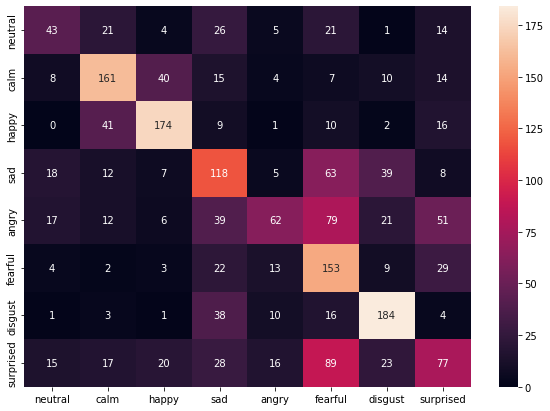

In [10]:
_,_, testset_loader = U.load_data(data_dir=data_dir, batch_size=best_trial.config['batch_size'])

labels = list(Rd.emocat.values())
y_true, y_pred = U.au_classiffication_accuracy(best_trained_model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:04<00:00, 417.75it/s]


              precision    recall  f1-score   support

     neutral       0.24      0.09      0.13      4129
        calm       0.18      0.99      0.31      4056
       happy       0.87      0.07      0.14      4121
         sad       0.68      0.08      0.15      4125
       angry       0.56      0.37      0.44      4026
     fearful       0.31      0.28      0.30      4104
     disgust       0.84      0.33      0.47      4062
   surprised       0.43      0.01      0.01      4145

    accuracy                           0.28     32768
   macro avg       0.51      0.28      0.24     32768
weighted avg       0.51      0.28      0.24     32768



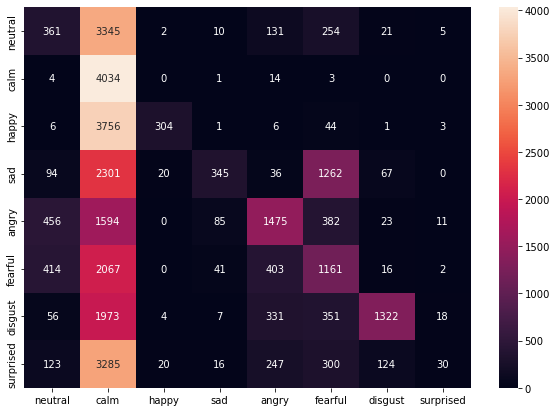

In [11]:
labels = list(Rd.emocat.values())
y_true, y_pred = U.au_recon_and_classiffication_accuracy(best_trained_model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

In [12]:
model_args =  {'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 25, 'hidden_dim': 512, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 262330.5833373258, 'emotion_weight': 1.0523573323659556, 'expert_type': 'poe', 'use_cuda': True}
train_args =  {'learning_rate': 0.001, 'alpha': 0.5, 'beta': 1e-05, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 128}